RandomForestClassifier/XGBClassifier/MLPClassifier with Shap

In [304]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import shap
from xgboost import XGBClassifier, DMatrix
from matplotlib.colors import LinearSegmentedColormap

from sklearn.neural_network import MLPClassifier
import json

In [305]:
# Categories of interest = {"Generic policy", "Reporting mechanism", "Scope of practice", "User guideline"}

selected_categories = 'Generic policy'

# Load datasets
df_train = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_train.json')
df_val = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_val.json')
df_test = pd.read_json(f'dataset/{selected_categories.replace(" ", "_")}_test.json')

#scale up the dataset
# df_train = pd.concat([df_train, df_train])
# df_val = pd.concat([df_val, df_val])
# df_test = pd.concat([df_test, df_test])

In [306]:
# Categories
categories = [
    'Generic policy', 'Reporting mechanism', 'Information on maintainer', 
    'Scope of practice', 'Project practice', 'History of vulnerability', 
    'User guideline', 'Additional information',
]

for category in categories:
    df_train[category] = df_train['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_val[category] = df_val['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)
    df_test[category] = df_test['SecurityPolicy_content_category'].apply(lambda x: 1 if category in str(x) else 0)

        
# Features
selected_features = ['num_commits', 'project_age_days', 'num_contributors', 
                     'num_issues', 'num_pull', 'num_opening_issue', 'project_size(kB)', 
                     'num_stargazers', 'num_watchers', 'num_forks', 'num_subscribers']

# Change category to be trained here
X_train, y_train = df_train[selected_features], df_train[selected_categories]
X_val, y_val = df_val[selected_features], df_val[selected_categories]
X_test, y_test = df_test[selected_features], df_test[selected_categories]

# print(y_train.value_counts())
# print(y_val.value_counts())
# print(y_test.value_counts())

In [307]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Check class distribution before oversampling
print("Before SMOTE:")
print(y_train.value_counts())
# print(y_val.value_counts())
# print(y_test.value_counts())

# Apply SMOTE to balance classes in training data
smote = SMOTE(sampling_strategy="auto", k_neighbors=3, random_state=42)  # Keep a slight imbalance
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# X_val_resampled, y_val_resampled = smote.fit_resample(X_val, y_val)
# X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Check class distribution after oversampling
print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
# print(pd.Series(y_val_resampled).value_counts())
# print(pd.Series(y_test_resampled).value_counts())


Before SMOTE:
Generic policy
1    145
0     66
Name: count, dtype: int64

After SMOTE:
Generic policy
1    145
0    145
Name: count, dtype: int64


In [308]:
# Encode target variables
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


Random forest Classification

best parameter: https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/ 
and https://tahera-firdose.medium.com/fine-tuning-your-random-forest-classifier-a-guide-to-hyperparameter-tuning-d5ceab0c4852

In [309]:
# Train Random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = rf_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.63
Validation Report:
              precision    recall  f1-score   support

           0       0.20      0.05      0.08        19
           1       0.67      0.90      0.77        41

    accuracy                           0.63        60
   macro avg       0.44      0.48      0.43        60
weighted avg       0.52      0.63      0.55        60

Test Accuracy: 0.74
Test Report:
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        10
           1       0.74      0.95      0.83        21

    accuracy                           0.74        31
   macro avg       0.75      0.63      0.63        31
weighted avg       0.74      0.74      0.70        31



In [310]:
# Define the classifier
rf_clf = RandomForestClassifier()

# Store classification reports and accuracies
val_reports = []
test_reports = []
val_accuracies = []
test_accuracies = []

# Run the model 10 times
for _ in range(10):
    rf_clf.fit(X_train, y_train)
    
    # Validation
    y_val_pred = rf_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    val_reports.append(val_report)
    
    # Testing
    y_test_pred = rf_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_reports.append(test_report)

# Compute average classification reports
def average_classification_report(reports):
    avg_report = {}
    for label in reports[0].keys():
        if isinstance(reports[0][label], dict):  # Normal classification labels
            avg_report[label] = {
                metric: np.mean([r[label][metric] for r in reports]) for metric in reports[0][label]
            }
        else:  # Handle 'accuracy' separately (it's a float)
            avg_report[label] = np.mean([r[label] for r in reports])
    return avg_report

avg_val_report = average_classification_report(val_reports)
avg_test_report = average_classification_report(test_reports)

# Convert results to DataFrame for visualization
df_val_report = pd.DataFrame(avg_val_report).T
df_test_report = pd.DataFrame(avg_test_report).T

print('val Report:')
print(df_val_report)


print('test Report:')
print(df_test_report)


val Report:
              precision    recall  f1-score    support
0              0.257143  0.078947  0.120161  19.000000
1              0.677119  0.895122  0.770945  41.000000
accuracy       0.636667  0.636667  0.636667   0.636667
macro avg      0.467131  0.487035  0.445553  60.000000
weighted avg   0.544126  0.636667  0.564863  60.000000
test Report:
              precision    recall  f1-score   support
0              0.803333  0.350000  0.483892  10.00000
1              0.755997  0.957143  0.844568  21.00000
accuracy       0.761290  0.761290  0.761290   0.76129
macro avg      0.779665  0.653571  0.664230  31.00000
weighted avg   0.771267  0.761290  0.728221  31.00000


100%|██████████| 31/31 [00:03<00:00,  9.41it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

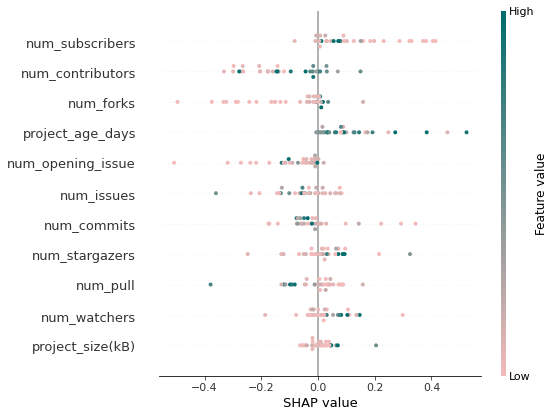

In [311]:
# Shap RF
explainer = shap.KernelExplainer(rf_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

XGBoost Classification

params: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

In [312]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     "n_estimators": [200, 300, 500],
#     "max_depth": [3, 4, 5],
#     "learning_rate": [0.01, 0.03, 0.05],
#     "min_child_weight": [3, 5, 7],
#     "gamma": [1, 3, 5]
# }

# grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)

# print("Best Parameters:", grid_search.best_params_)


In [313]:

xg_clf = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.05, colsample_bytree=0.8, subsample=0.8)
xg_clf.fit(X_train, y_train)

# Validate XGB
y_val_pred = xg_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test XGB
y_test_pred = xg_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.65
Validation Report:
              precision    recall  f1-score   support

           0       0.42      0.26      0.32        19
           1       0.71      0.83      0.76        41

    accuracy                           0.65        60
   macro avg       0.56      0.55      0.54        60
weighted avg       0.62      0.65      0.62        60

Test Accuracy: 0.81
Test Report:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.80      0.95      0.87        21

    accuracy                           0.81        31
   macro avg       0.82      0.73      0.75        31
weighted avg       0.81      0.81      0.79        31



In [314]:
# Define the XGBoost classifier with specified parameters
xg_clf = XGBClassifier()

# Store classification reports and accuracies
xgb_val_reports = []
xgb_test_reports = []
xgb_val_accuracies = []
xgb_test_accuracies = []

# Run the model 10 times
for _ in range(10):
    xg_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = xg_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    xgb_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    xgb_val_reports.append(val_report)

    # Testing
    y_test_pred = xg_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    xgb_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    xgb_test_reports.append(test_report)

# Compute average classification reports
avg_xgb_val_report = average_classification_report(xgb_val_reports)
avg_xgb_test_report = average_classification_report(xgb_test_reports)

# Convert results to DataFrame for visualization
df_xgb_val_report = pd.DataFrame(avg_xgb_val_report).T
df_xgb_test_report = pd.DataFrame(avg_xgb_test_report).T

print('val Report:')
print(df_xgb_val_report)

print('test Report:')
print(df_xgb_test_report)



val Report:
              precision    recall  f1-score    support
0              0.300000  0.157895  0.206897  19.000000
1              0.680000  0.829268  0.747253  41.000000
accuracy       0.616667  0.616667  0.616667   0.616667
macro avg      0.490000  0.493582  0.477075  60.000000
weighted avg   0.559667  0.616667  0.576140  60.000000
test Report:
              precision    recall  f1-score    support
0              0.625000  0.500000  0.555556  10.000000
1              0.782609  0.857143  0.818182  21.000000
accuracy       0.741935  0.741935  0.741935   0.741935
macro avg      0.703804  0.678571  0.686869  31.000000
weighted avg   0.731767  0.741935  0.733464  31.000000


Text(0.5, 32.10000000000005, 'SHAP value')

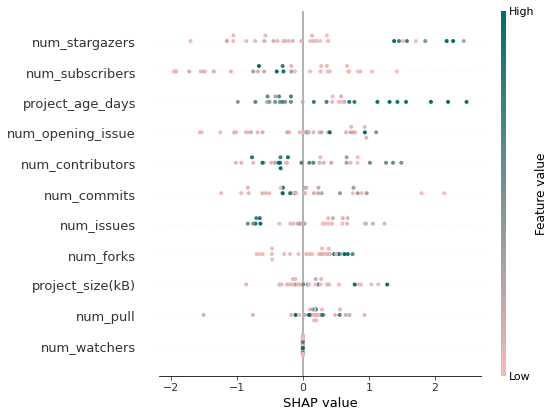

In [315]:
# Shap XGB
explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel("SHAP value")

NN MLPClassifier

In [316]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = mlp_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = mlp_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Validation Accuracy: 0.55
Validation Report:
              precision    recall  f1-score   support

           0       0.17      0.11      0.13        19
           1       0.65      0.76      0.70        41

    accuracy                           0.55        60
   macro avg       0.41      0.43      0.41        60
weighted avg       0.49      0.55      0.52        60

Test Accuracy: 0.61
Test Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        10
           1       0.71      0.71      0.71        21

    accuracy                           0.61        31
   macro avg       0.56      0.56      0.56        31
weighted avg       0.61      0.61      0.61        31



In [317]:
# Define the MLP classifier
mlp_clf = MLPClassifier()

# Store classification reports and accuracies
mlp_val_reports = []
mlp_test_reports = []
mlp_val_accuracies = []
mlp_test_accuracies = []

# Run the model 10 times
for _ in range(10):
    mlp_clf.fit(X_train, y_train)

    # Validation
    y_val_pred = mlp_clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    mlp_val_accuracies.append(val_accuracy)
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    mlp_val_reports.append(val_report)

    # Testing
    y_test_pred = mlp_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    mlp_test_accuracies.append(test_accuracy)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    mlp_test_reports.append(test_report)

# Compute average classification reports
avg_mlp_val_report = average_classification_report(mlp_val_reports)
avg_mlp_test_report = average_classification_report(mlp_test_reports)

# Convert results to DataFrame for visualization
df_mlp_val_report = pd.DataFrame(avg_mlp_val_report).T
df_mlp_test_report = pd.DataFrame(avg_mlp_test_report).T

print('val Report:')
print(df_mlp_val_report)

print('test Report:')
print(df_mlp_test_report)


val Report:
              precision    recall  f1-score    support
0              0.424654  0.315789  0.284409  19.000000
1              0.697320  0.721951  0.688304  41.000000
accuracy       0.593333  0.593333  0.593333   0.593333
macro avg      0.560987  0.518870  0.486357  60.000000
weighted avg   0.610976  0.593333  0.560404  60.000000
test Report:
              precision    recall  f1-score    support
0              0.434524  0.320000  0.324825  10.000000
1              0.710111  0.780952  0.730675  21.000000
accuracy       0.632258  0.632258  0.632258   0.632258
macro avg      0.572318  0.550476  0.527750  31.000000
weighted avg   0.621212  0.632258  0.599756  31.000000


C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Beebie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classific

100%|██████████| 31/31 [00:02<00:00, 11.26it/s]


Text(0.5, 32.10000000000005, 'SHAP value')

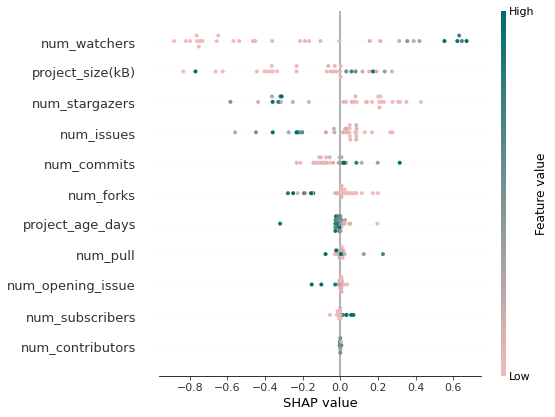

In [318]:
# Shap MLP
explainer = shap.KernelExplainer(mlp_clf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

cmap = LinearSegmentedColormap.from_list("custom", ["#f3baba", "#006C6C"])
shap.summary_plot(shap_values, X_test, cmap=cmap, show=False)
# plt.title("Generic policy", fontsize=20)
plt.xlabel(f"SHAP value")

In [322]:
from catboost import CatBoostClassifier, CatBoostRegressor

cat_clf = CatBoostClassifier()
cat_clf.fit(X_train, y_train)

# Validate RF
y_val_pred = cat_clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print('Validation Report:')
print(classification_report(y_val, y_val_pred))

# Test RF
y_test_pred = cat_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')
print('Test Report:')
print(classification_report(y_test, y_test_pred))

Learning rate set to 0.005302
0:	learn: 0.6913402	total: 19.2ms	remaining: 19.2s
1:	learn: 0.6899964	total: 21.7ms	remaining: 10.8s
2:	learn: 0.6885220	total: 24ms	remaining: 7.97s
3:	learn: 0.6866848	total: 25.9ms	remaining: 6.45s
4:	learn: 0.6848736	total: 27.8ms	remaining: 5.54s
5:	learn: 0.6835240	total: 29.9ms	remaining: 4.96s
6:	learn: 0.6821094	total: 31.7ms	remaining: 4.5s
7:	learn: 0.6802191	total: 33.4ms	remaining: 4.14s
8:	learn: 0.6787593	total: 35.3ms	remaining: 3.89s
9:	learn: 0.6772961	total: 37.6ms	remaining: 3.72s
10:	learn: 0.6760650	total: 39.4ms	remaining: 3.54s
11:	learn: 0.6741219	total: 40.9ms	remaining: 3.37s
12:	learn: 0.6727523	total: 42.5ms	remaining: 3.23s
13:	learn: 0.6715953	total: 44.6ms	remaining: 3.14s
14:	learn: 0.6698811	total: 46.6ms	remaining: 3.06s
15:	learn: 0.6686609	total: 48.6ms	remaining: 2.99s
16:	learn: 0.6674726	total: 50.2ms	remaining: 2.9s
17:	learn: 0.6660597	total: 51.8ms	remaining: 2.82s
18:	learn: 0.6647030	total: 53.4ms	remaining: 2.